In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import sweetviz as sv
import xgboost as xgb
from sklearn import svm
import category_encoders as ce
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import FastICA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
heart_dis_pred = pd.read_csv("heart_cleaned_encoded_smote.csv")

In [5]:
from sklearn.model_selection import train_test_split

predictors = heart_dis_pred.drop("HeartDisease_No",axis=1)
target = heart_dis_pred["HeartDisease_No"]

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

# Decision Tree with Scaling + SMOTE

In [6]:
%%time

max_accuracy = 0

for x in range(200):
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(X_train,Y_train)
    Y_pred_dt = dt.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_dt,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)

dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(X_train,Y_train)

Wall time: 26min 49s


DecisionTreeClassifier(random_state=112)

In [7]:
Y_pred_dt = dt.predict(X_test)

In [8]:
pkl.dump(dt, open('model_dt.pkl', 'wb'))

In [9]:
yTest = Y_test.to_frame(name = "HeartDisease_No")
tn, fp, fn, tp = confusion_matrix(yTest, Y_pred_dt).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  43409 
False positives:  3331 
False negatives:  3748 
True Positives:  43088


In [10]:
print(classification_report(yTest, Y_pred_dt))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     46740
           1       0.93      0.92      0.92     46836

    accuracy                           0.92     93576
   macro avg       0.92      0.92      0.92     93576
weighted avg       0.92      0.92      0.92     93576



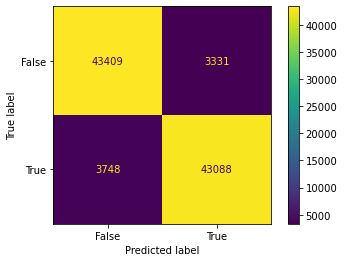

In [11]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(yTest['HeartDisease_No'], Y_pred_dt)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

C:\Users\chemb\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


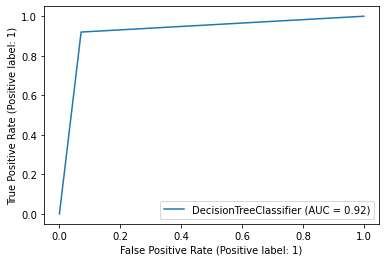

In [12]:
test = pd.concat([X_test, Y_test], axis=1)
# from deepchecks.checks import RocReport
# from deepchecks import Dataset
# RocReport().run(Dataset(test, label='HeartDisease_No'), dt)
metrics.plot_roc_curve(dt, X_test, Y_test)

# Decision Tree with Scaling + SMOTE + PCA

In [13]:
heart_dis_train_pred = pd.read_csv("heart_cleaned_encoded_trained_pca.csv")
heart_dis_test_pred = pd.read_csv("heart_cleaned_encoded_tested_pca.csv")

In [14]:
%%time

features = ['principal component 1','principal component 2','principal component 3','principal component 4','principal component 5','principal component 6','principal component 7','principal component 8','principal component 9','principal component 10','principal component 11','principal component 12','principal component 13','principal component 14','principal component 15','principal component 16','principal component 17','principal component 18','principal component 19','principal component 20']

max_accuracy = 0

for x in range(200):
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(heart_dis_train_pred[features],heart_dis_train_pred["HeartDisease_No"])
    Y_pred_dt = dt.predict(heart_dis_test_pred[features])
    current_accuracy = round(accuracy_score(Y_pred_dt,heart_dis_test_pred["HeartDisease_No"])*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)

dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(heart_dis_train_pred[features],heart_dis_train_pred["HeartDisease_No"])


Wall time: 3h 16s


DecisionTreeClassifier(random_state=73)

In [15]:
Y_pred_dt = dt.predict(heart_dis_test_pred[features])

In [16]:
pkl.dump(dt, open('model_dt_pca.pkl', 'wb'))

In [17]:
tn, fp, fn, tp = metrics.confusion_matrix(heart_dis_test_pred["HeartDisease_No"], Y_pred_dt).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  2199 
False positives:  3276 
False negatives:  9482 
True Positives:  49002


In [18]:
print(classification_report(heart_dis_test_pred["HeartDisease_No"], Y_pred_dt))

              precision    recall  f1-score   support

           0       0.19      0.40      0.26      5475
           1       0.94      0.84      0.88     58484

    accuracy                           0.80     63959
   macro avg       0.56      0.62      0.57     63959
weighted avg       0.87      0.80      0.83     63959



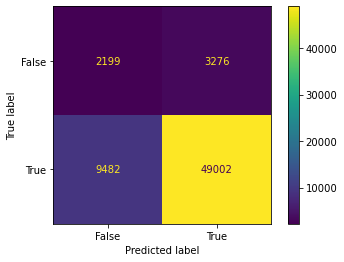

In [19]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(heart_dis_test_pred['HeartDisease_No'], Y_pred_dt)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

C:\Users\chemb\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


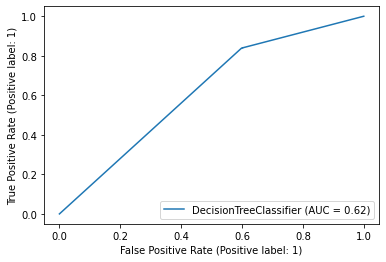

In [20]:
# from deepchecks.checks import RocReport
# from deepchecks import Dataset
# RocReport().run(Dataset(heart_dis_test_pred, label='HeartDisease_No'), dt)
metrics.plot_roc_curve(dt, heart_dis_test_pred[features], heart_dis_test_pred["HeartDisease_No"])

# Decision Tree with Scaling + SMOTE + ICA

In [21]:
heart_dis_train_pred = pd.read_csv("heart_cleaned_encoded_trained_ica.csv")
heart_dis_test_pred = pd.read_csv("heart_cleaned_encoded_tested_ica.csv")

In [22]:
%%time

features = ['independent component 1','independent component 2','independent component 3','independent component 4','independent component 5','independent component 6','independent component 7','independent component 8','independent component 9','independent component 10','independent component 11','independent component 12','independent component 13','independent component 14','independent component 15','independent component 16','independent component 17','independent component 18','independent component 19','independent component 20']

max_accuracy = 0

for x in range(200):
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(heart_dis_train_pred[features],heart_dis_train_pred["HeartDisease_No"])
    Y_pred_dt = dt.predict(heart_dis_test_pred[features])
    current_accuracy = round(accuracy_score(Y_pred_dt,heart_dis_test_pred["HeartDisease_No"])*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)

dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(heart_dis_train_pred[features],heart_dis_train_pred["HeartDisease_No"])

Wall time: 1h 39min 38s


DecisionTreeClassifier(random_state=6)

In [23]:
Y_pred_dt = dt.predict(heart_dis_test_pred[features])

In [24]:
pkl.dump(dt, open('model_dt_ica.pkl', 'wb'))

In [25]:
tn, fp, fn, tp = metrics.confusion_matrix(heart_dis_test_pred["HeartDisease_No"], Y_pred_dt).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  2120 
False positives:  3355 
False negatives:  8240 
True Positives:  50244


In [26]:
print(classification_report(heart_dis_test_pred["HeartDisease_No"], Y_pred_dt))

              precision    recall  f1-score   support

           0       0.20      0.39      0.27      5475
           1       0.94      0.86      0.90     58484

    accuracy                           0.82     63959
   macro avg       0.57      0.62      0.58     63959
weighted avg       0.87      0.82      0.84     63959



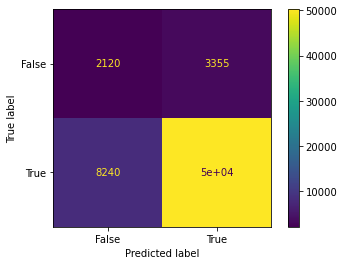

In [27]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(heart_dis_test_pred['HeartDisease_No'], Y_pred_dt)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

C:\Users\chemb\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


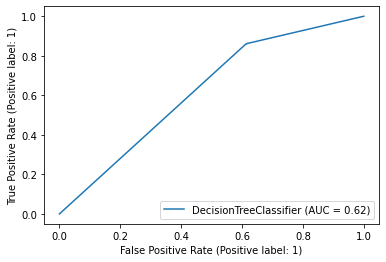

In [28]:
# from deepchecks.checks import RocReport
# from deepchecks import Dataset
# RocReport().run(Dataset(heart_dis_test_pred, label='HeartDisease_No'), dt)
metrics.plot_roc_curve(dt, heart_dis_test_pred[features], heart_dis_test_pred["HeartDisease_No"])

# Decision Tree with Scaling + SMOTE + LDA

In [29]:
heart_dis_train_pred = pd.read_csv("heart_cleaned_encoded_trained_lda.csv")
heart_dis_test_pred = pd.read_csv("heart_cleaned_encoded_tested_lda.csv")

In [30]:
%%time

features = ['lda 1']

max_accuracy = 0

for x in range(200):
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(heart_dis_train_pred[features],heart_dis_train_pred["HeartDisease_No"])
    Y_pred_dt = dt.predict(heart_dis_test_pred[features])
    current_accuracy = round(accuracy_score(Y_pred_dt,heart_dis_test_pred["HeartDisease_No"])*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)

dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(heart_dis_train_pred[features],heart_dis_train_pred["HeartDisease_No"])

Wall time: 11min 26s


DecisionTreeClassifier(random_state=0)

In [31]:
Y_pred_dt = dt.predict(heart_dis_test_pred[features])

In [32]:
pkl.dump(dt, open('model_dt_lda.pkl', 'wb'))

In [33]:
tn, fp, fn, tp = metrics.confusion_matrix(heart_dis_test_pred["HeartDisease_No"], Y_pred_dt).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  3643 
False positives:  1832 
False negatives:  18589 
True Positives:  39895


In [34]:
print(classification_report(heart_dis_test_pred["HeartDisease_No"], Y_pred_dt))

              precision    recall  f1-score   support

           0       0.16      0.67      0.26      5475
           1       0.96      0.68      0.80     58484

    accuracy                           0.68     63959
   macro avg       0.56      0.67      0.53     63959
weighted avg       0.89      0.68      0.75     63959



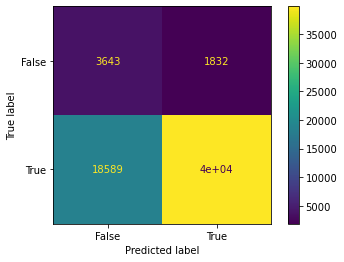

In [35]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(heart_dis_test_pred['HeartDisease_No'], Y_pred_dt)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\checks.py:21: DeprecationWarning:

Ability to import tabular checks from the `deepchecks.checks` is deprecated, please import from `deepchecks.tabular.checks` instead

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepchecks.tabular` instead

C:\Users\chemb\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



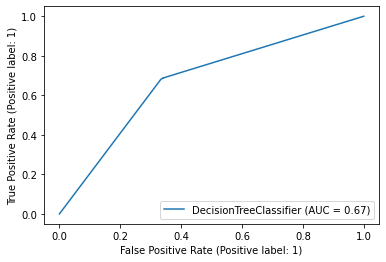

In [36]:
from deepchecks.checks import RocReport
from deepchecks import Dataset
metrics.plot_roc_curve(dt, heart_dis_test_pred[features], heart_dis_test_pred["HeartDisease_No"])